# **Applying PINN to the Marmousi Velocity Model**  

This notebook provides a direct comparison between Physics-Informed Neural Networks (PINNs) and a novel Physics-Informed Kolmogorov-Arnold Network (PI-KAN) for seismic ray tracing.

When applied to complex velocity fields like the Marmousi model, standard KANs risk overfitting. By embedding the governing physical equations, the PI-KAN architecture is regularized, forcing it to learn solutions that are both data-driven and physically plausible. To ensure a fair and direct comparison of architectural benefits, both the PINN and PI-KAN models are constructed with an equivalent number of trainable parameters.

## **Setup**

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import random
from typing import Union
from itertools import cycle, product
from functools import partial
from pathlib import Path
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.graph_objects as go

from tqdm.auto import tqdm
from kan import KAN

import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Sampler
from utils.architecture import ArchitectureMLP, Architecture
from rt_python import DataGeneratorMarmousi
from utils.metrics import score

SEED = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Use CUDA device when available. Otherwise, use CPU device.

In [14]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using '{DEVICE}' device.")

Using 'cuda' device.


Setup your path to data, output and checkpoint folders. 

In [30]:
DATA_PATH = Path("../data/mlp")
OUTPUT_PATH = Path("../output/mlp")
CHECKPOINT_PATH = OUTPUT_PATH/"model"

model_save_path = "output/mlp/mlp.pt"

## **Data Acquisition**

The dataset used in this study is derived from the Marmousi velocity model, a well-known synthetic benchmark in geophysics. This model represents a highly complex subsurface with strong velocity variations, making it ideal for testing ray-tracing algorithms and machine-learning approaches in seismic imaging.

To improve numerical stability and facilitate more efficient training, we normalize the velocity values by converting them to **km/s**. This transformation mitigates scale discrepancies (e.g., values ranging from 10 to 10,000), ensuring better gradient propagation and more stable optimization during model training.

In [16]:
# Model parameters
nx = 2301  # Number of samples in the distance dimension
nz = 751   # Number of samples in the depth dimension
dz = 4     # Distance increment (m)
dx = 4     # Depth increment (m)

# Model limits in km
xmax = nx * dx / 1000
zmax = nz * dz / 1000

vp_file = "../data/marmousi_vp.bin"

vp = np.fromfile(vp_file, dtype=np.dtype('float32').newbyteorder('<'))
vp = vp.reshape((nx, nz)).transpose() / 1000  # Converting to km/s
vp.shape

(751, 2301)

Visualizing the Marmousi Velocity Model with Matplotlib

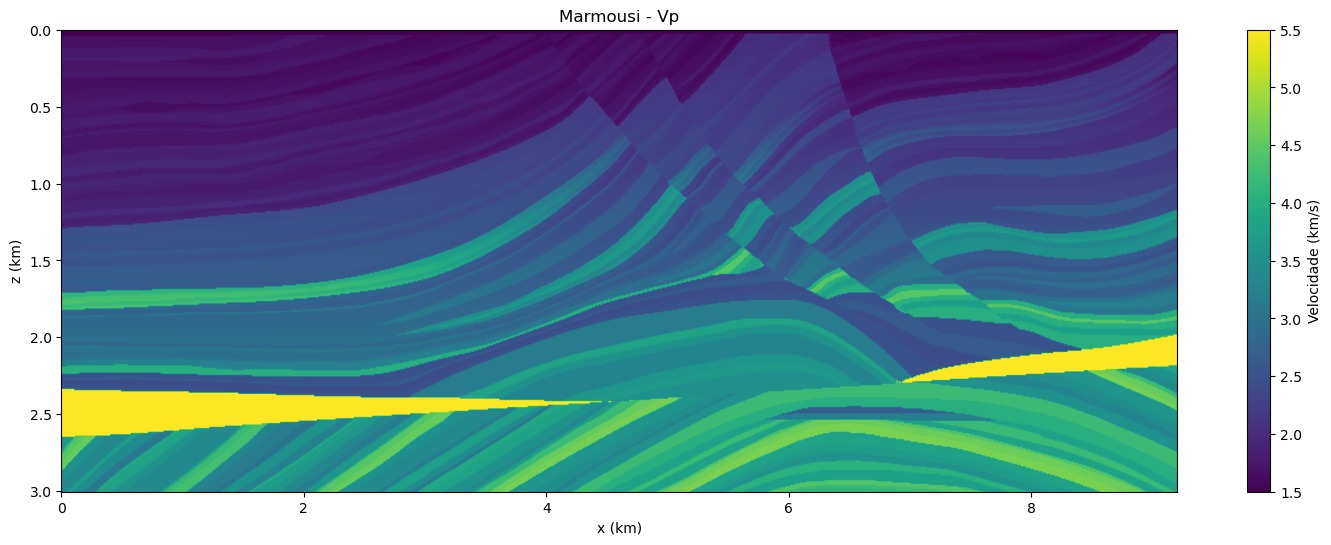

In [17]:
plt.figure(figsize=(18, 6))
plt.imshow(vp, extent=[0, xmax, zmax, 0], aspect='auto', cmap='viridis')
plt.colorbar(label="Velocidade (km/s)")
plt.title("Marmousi - Vp")
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.show()

### **Ray-Tracing Data Generation and Visualization Using `DataGeneratorMarmousi`**

The **`DataGeneratorMarmousi`** class systematically generates ray-tracing data within the **Marmousi velocity model**, enabling machine learning-driven approaches in seismic modeling. By leveraging B-spline interpolation and numerical integration, it constructs high-quality training datasets that capture wave propagation dynamics. The class extends `DataGenerator`, inheriting core spatial attributes without redefining the constructor. Its key method, `run_multiple`, generates ray trajectories across a predefined range of initial positions `(x0, z0)` and angles `(θ0)`, ensuring comprehensive sampling of the velocity model. This process involves interpolating the velocity field for smooth representation, numerically solving ray equations, and aggregating the computed paths into a structured **DataFrame**. The resulting dataset is optimized for training **Kolmogorov-Arnold Networks (KANs)** and other ML models, providing a physics-informed foundation for learning seismic wave behavior while maintaining computational efficiency.  

The code below initializes an instance of `DataGeneratorMarmousi` and generates a dataset of ray-tracing paths within the **Marmousi velocity model**. The process consists of three main steps:  

1. **Defining the Spatial Domain**:  
   The `x_range` and `z_range` parameters define the horizontal and depth extents of the velocity model, ranging from `0` to `xmax` and `0` to `zmax`, respectively. These boundaries ensure that rays are traced within the predefined seismic model.  

2. **Generating Ray-Tracing Data (`run_multiple`)**:  
   The method `run_multiple` is called to compute multiple ray trajectories, systematically sampling different initial conditions:
   - **`x0_range=(4, 6)` and `z0_range=(1, 2)`**: Specifies that rays originate from positions within these spatial bounds.  
   - **`theta_range=(45, 75)`**: Defines the range of initial propagation angles in degrees.  
   - **`vp=vp`**: Passes the Marmousi velocity model as input.  
   - **`factor=30`**: Controls the downsampling of the velocity field for computational efficiency.  
   - **`dx_dy=0.1`**: Sets the resolution for sampling initial positions.  

   The method iterates over all combinations of `(x0, z0, θ0)`, computes the corresponding ray trajectories, and stores the results in a structured **DataFrame** (`df`). This dataset includes the spatial evolution of each ray over time, along with its velocity and direction of propagation.  

3. **Visualization (`plot`)**:  
   The `plot` method visualizes the generated ray paths overlaid on the velocity model. The **velocity field** is represented as a colormap, while the **ray trajectories** illustrate how seismic waves travel through the subsurface. The figure size `(22,6)` ensures clarity, and `plt.show()` displays the plot.  

This workflow effectively generates a diverse dataset for **machine learning applications**, such as training **Kolmogorov-Arnold Networks (KANs)** to learn seismic wave propagation patterns while maintaining physical consistency.


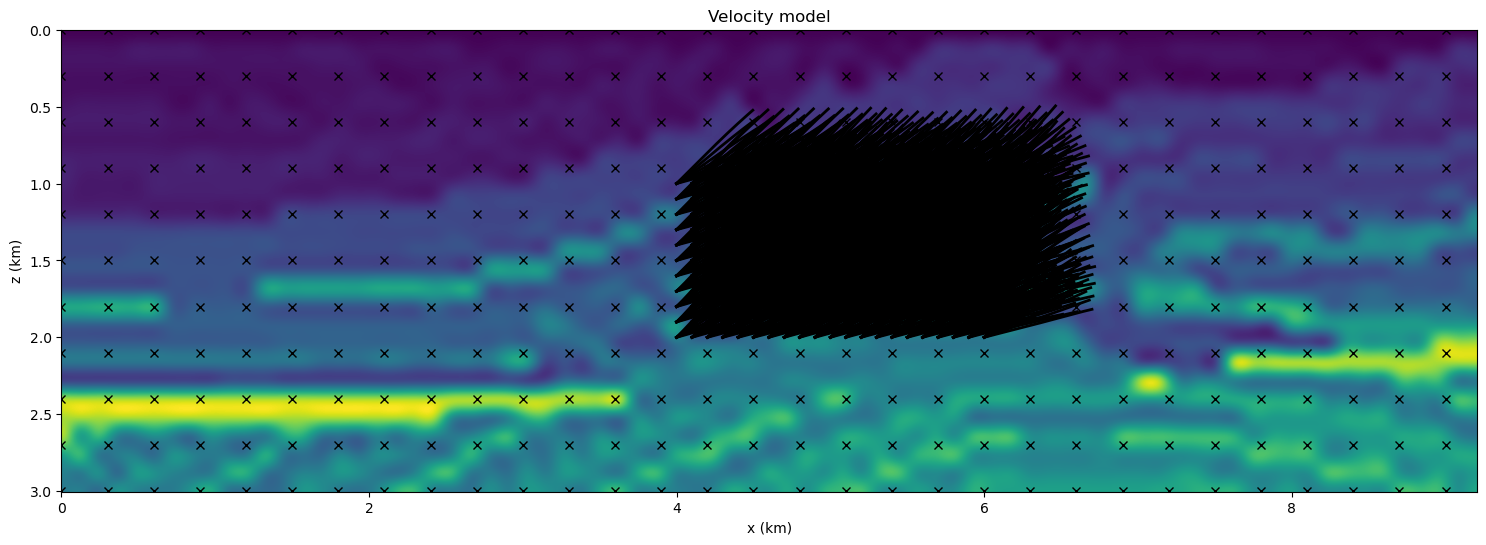

In [11]:
x_range = (0, xmax)
z_range = (0, zmax)

data_gen = DataGeneratorMarmousi(
    x_range=x_range,
    z_range=z_range
)
df = data_gen.run_multiple(x0_range=(4, 6),
                           z0_range=(1, 2),
                           theta_range=(45, 75),
                           vp=vp,
                           factor=30,
                           dx_dy=0.1,
                           dtheta=5,
                           t_max=0.4,
                           )
fig = data_gen.plot(df, figsize=(22, 6))
plt.show()

Here, we define the feature groups for our architecture: **KAN features** (inputs to the Kolmogorov-Arnold Network), **Arch features** (KAN features plus additional features used in the PIN module), and **target features** (the predicted output). This organization ensures a clear and structured data flow within the model.

In [12]:
kan_features = ['x0', 'z0', 'theta0_p', 't']
arch_features = kan_features + ['pi_weight', 'dxdt', 'dzdt', 'dpxdt', 'dpzdt']
target = ['x', 'z', 'px', 'pz']

### **Weights in PINN Loss Function**  

In **Physics-Informed Neural Networks (PINNs)**, loss weighting plays a crucial role in balancing data-driven learning with physical constraints. The weights used in the PINN loss function dynamically adjust the contribution of data and physics-based constraints. In regions with dense data points, the model prioritizes data fidelity, while in sparsely sampled areas, it emphasizes adherence to the governing equations. This adaptive weighting ensures a balanced learning process, improving generalization across the entire domain.  

Here, the **weighting strategy is based on spatial frequency**. The code computes the number of data points within predefined spatial regions (squares), assigning higher weights to underrepresented areas and lower weights to densely populated regions. This **adaptive weighting** prevents the model from overfitting high-density regions and helps it generalize across the entire domain.  

By incorporating these weights into the PINN loss function, the model effectively learns from both observed data and physics-based constraints, leading to improved stability, accuracy, and robustness in solving inverse problems in seismic modeling.

In [18]:
def get_squares_limits(data: pd.DataFrame, restrictions: dict, step: float) -> np.ndarray:
    """
    Generates a set of square limits based on specified feature restrictions and step size.

    This function partitions the feature space into discrete intervals based on given restrictions,
    creating a grid of square regions for further analysis.

    Args:
        data (pd.DataFrame): The input dataset containing feature columns.
        restrictions (dict): A dictionary defining the range of each feature. 
            Each key corresponds to a feature name, and its value is a dictionary 
            with 'min' and 'max' keys specifying the range.
        step (float): The step size used to discretize the feature space.

    Returns:
        np.ndarray: A NumPy array containing all possible square intervals formed by the 
        specified feature restrictions.
    
    Raises:
        AssertionError: If any feature in `restrictions` is not present in the dataset.

    Example:
        >>> data = pd.DataFrame({'x': [1, 2, 3], 'y': [4, 5, 6]})
        >>> restrictions = {'x': {'min': 0, 'max': 3}, 'y': {'min': 4, 'max': 6}}
        >>> get_squares_limits(data, restrictions, step=1)
        array([[[0., 1.], [4., 5.]],
               [[0., 1.], [5., 6.]],
               [[1., 2.], [4., 5.]],
               [[1., 2.], [5., 6.]],
               [[2., 3.], [4., 5.]],
               [[2., 3.], [5., 6.]]], dtype=float32)
    """
    assert all([feature in data.columns for feature in restrictions.keys()]), \
        "Some features presented in restrictions are not in the data."

    # Generate the intervals for each feature
    limits_map = {}
    for name, boundary in restrictions.items():
        aux = np.arange(boundary['min'], boundary['max'] + step, step=step, dtype='float32')
        aux = [round(x, 3) for x in aux]
        limits_map[name] = [(aux[i], aux[i+1]) for i in range(len(aux) - 1)]

    # Create all combinations of the intervals between features
    combinations = list(product(*limits_map.values()))

    result = [np.array(combination, dtype='float32') for combination in combinations]

    return np.array(result, dtype='float32')

In [19]:
def get_frequency(data: pd.DataFrame, restrictions: dict, step: float = 0.1) -> pd.DataFrame:
    """
    Computes the frequency of data points within predefined square regions in the feature space.

    This function divides the input data into grid-based square regions and counts the number 
    of data points falling within each region. The result is stored in a DataFrame.

    Args:
        data (pd.DataFrame): The dataset containing the features to be analyzed.
        restrictions (dict): A dictionary defining feature-wise range restrictions.
            Each key corresponds to a feature name, with 'min' and 'max' specifying the range.
        step (float, optional): The step size used to define square regions. Default is 0.1.

    Returns:
        pd.DataFrame: A DataFrame containing each square's limits and the corresponding data point count.

    Example:
        >>> data = pd.DataFrame({'x': [0.5, 1.5, 2.5], 'y': [4.5, 5.5, 6.5]})
        >>> restrictions = {'x': {'min': 0, 'max': 3}, 'y': {'min': 4, 'max': 6}}
        >>> get_frequency(data, restrictions, step=1)
           square   frequency
        0  [[0, 1], [4, 5]]  1
        1  [[0, 1], [5, 6]]  0
        2  [[1, 2], [4, 5]]  0
        3  [[1, 2], [5, 6]]  1
        4  [[2, 3], [4, 5]]  0
        5  [[2, 3], [5, 6]]  1
    """
    squares_limits = get_squares_limits(data, restrictions, step)

    # Count points in each square
    frequencies = []
    for square in squares_limits:
        mask = np.ones(len(data), dtype=bool)
        for feature, limits in zip(restrictions.keys(), square):
            sqr_min, sqr_max = limits
            mask &= (data[feature] >= sqr_min) & (data[feature] < sqr_max)

        # Count points inside this square
        frequencies.append(np.sum(mask))

    # Prepare result as a DataFrame
    frequency_df = pd.DataFrame(
        data={
            "square": list(squares_limits),
            "frequency": frequencies
        }
    )

    return frequency_df


In [20]:
def add_frequency_to_data(data: pd.DataFrame, frequency_df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds frequency information to the dataset based on predefined spatial regions.

    This function assigns a frequency value to each data point by matching it to the 
    corresponding region (square) defined in `frequency_df`. The frequency represents 
    the number of data points found in that region, ensuring that each sample is 
    weighted accordingly for further processing.

    Args:
        data (pd.DataFrame): The input dataset containing feature columns.
        frequency_df (pd.DataFrame): A DataFrame with frequency counts for different 
            spatial regions, where each row contains:
            - "square": A list of tuples defining the boundaries of the region.
            - "frequency": The number of data points within that region.

    Returns:
        pd.DataFrame: A copy of `data` with an added "frequency" column.

    Example:
        >>> data = pd.DataFrame({'x': [0.5, 1.5, 2.5], 'y': [4.5, 5.5, 6.5]})
        >>> frequency_df = pd.DataFrame({
        ...     "square": [[(0,1), (4,5)], [(1,2), (5,6)], [(2,3), (6,7)]],
        ...     "frequency": [10, 5, 3]
        ... })
        >>> add_frequency_to_data(data, frequency_df)
             x    y  frequency
        0  0.5  4.5        10
        1  1.5  5.5         5
        2  2.5  6.5         3
    """
    # Initialize an array to store frequency values
    frequencies = np.zeros(len(data), dtype=int)

    # Iterate over each row in the frequency DataFrame to assign frequencies
    for _, square_row in frequency_df.iterrows():
        square = square_row['square']
        frequency = square_row['frequency']

        # Build a mask to filter the rows in `data` that fall within the current square
        mask = np.ones(len(data), dtype=bool)
        for feature, (min_val, max_val) in zip(data.columns, square):
            mask &= (data[feature] >= min_val) & (data[feature] < max_val)

        # Assign the frequency value to the matching rows
        frequencies[mask] = frequency

    # Create a copy of the dataset and add the frequency column
    data_with_frequency = data.copy()
    data_with_frequency['frequency'] = frequencies

    return data_with_frequency


In [21]:
def plot_surface(data: pd.DataFrame, filename: str = "output/surface_plot.html") -> None:
    """
    Generates a 3D surface plot of point frequencies within spatial regions.

    This function visualizes the frequency distribution of data points across 
    predefined grid regions. It extracts midpoints of the spatial squares and 
    maps the corresponding frequencies, creating a structured 3D surface plot 
    using Plotly.

    Args:
        data (pd.DataFrame): A DataFrame containing:
            - "square": A list of tuples defining the spatial region boundaries.
            - "frequency": The count of data points within each square.
        filename (str, optional): The output file path to save the interactive 
            HTML plot. Default is `"output/surface_plot.html"`.

    Returns:
        None: The function generates and saves the plot but does not return a value.

    Example:
        >>> data = pd.DataFrame({
        ...     "square": [[(0,1), (4,5)], [(1,2), (5,6)], [(2,3), (6,7)]],
        ...     "frequency": [10, 5, 3]
        ... })
        >>> plot_surface(data, filename="surface_plot.html")
    """
    # Extract midpoints and corresponding frequencies
    squares = data['square'].tolist()  # Assuming 'square' column stores lists
    frequencies = data['frequency'].values

    # Compute midpoints for visualization
    x = np.array([(interval[0][0] + interval[0][1]) / 2 for interval in squares])
    y = np.array([(interval[1][0] + interval[1][1]) / 2 for interval in squares])
    z = frequencies

    # Create a structured grid for the surface plot
    unique_x = np.unique(x)
    unique_y = np.unique(y)
    X, Z = np.meshgrid(unique_x, unique_y)

    # Map frequency values to the grid
    freq = np.zeros_like(X)
    for i, x_val in enumerate(unique_x):
        for j, y_val in enumerate(unique_y):
            mask = (x == x_val) & (y == y_val)
            if np.any(mask):
                freq[j, i] = z[mask][0]  # Assign the frequency to the grid point

    # Create 3D surface plot
    fig = go.Figure()
    fig.add_trace(go.Surface(z=freq, x=X, y=Z, opacity=0.8))

    # Customize layout
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Z',
            zaxis_title='Frequency'
        ),
        title='Surface Plot of Points in Squares'
    )

    # Save plot as an interactive HTML file
    fig.write_html(filename)


### **Splitting the Dataset into Training, Validation, and Test Sets**  

Proper dataset partitioning is essential to ensure robust model evaluation and generalization. Here, we divide the data into **training, validation, and test sets**, ensuring that the model learns effectively while being evaluated on unseen data. The **training set** is used to optimize model parameters, the **validation set** helps fine-tune hyperparameters and prevent overfitting, and the **test set** provides an unbiased estimate of final model performance.  


In [22]:
df.shape

(648417, 15)

In [23]:
initial_conditions = df[['x0', 'z0', 'theta0_p']].drop_duplicates()
aux = initial_conditions.copy()

ic_train = aux.sample(frac=0.6, random_state=SEED)
ic_val = aux.drop(ic_train.index).sample(frac=0.5, random_state=SEED)
ic_test = aux.drop(list(ic_train.index) + list(ic_val.index))

print("Train Initial Conditions:", len(ic_train))
print("Validation Initial Conditions:", len(ic_val))
print("Test Initial Conditions:", len(ic_test))

Train Initial Conditions: 970
Validation Initial Conditions: 324
Test Initial Conditions: 323


In [24]:
initial_conditions.shape

(1617, 3)

A total of **401 points** are used to construct the ray trajectory, covering a time range from **0 to 400 ms** with a time step (**dt**) of **1 ms**. This high-resolution sampling ensures precise tracking of wave propagation dynamics, improving the accuracy of trajectory estimation.  

In [25]:
df_train = df.merge(ic_train, on=['x0', 'z0', 'theta0_p'], how='inner')
df_val = df.merge(ic_val, on=['x0', 'z0', 'theta0_p'], how='inner')
df_test = df.merge(ic_test, on=['x0', 'z0', 'theta0_p'], how='inner')

print("Train Size:", len(df_train))
print("Validation Size:", len(df_val))
print("Test Size:", len(df_test))

Train Size: 388970
Validation Size: 129924
Test Size: 129523


### Save dataset

In [35]:
df_train.to_csv(DATA_PATH/'train_mlp.csv', index=False)
df_val.to_csv(DATA_PATH/'val_mlp.csv', index=False)
df_test.to_csv(DATA_PATH/'test_mlp.csv', index=False)

### Read dataset

In [37]:
df_train = pd.read_csv(DATA_PATH/'train_mlp.csv')
df_val = pd.read_csv(DATA_PATH/'val_mlp.csv')
df_test = pd.read_csv(DATA_PATH/'test_mlp.csv')

### Plot frequencies

In [38]:
restrictions = {
    'x': {'min': 0, 'max': xmax},
    'z': {'min': 0, 'max': zmax},
}
frequency_df = get_frequency(df_train, restrictions)

In [39]:
plot_surface(frequency_df, filename=DATA_PATH/"frequency_plot_mlp.html")

In [40]:
df_train_freq = add_frequency_to_data(df_train, frequency_df)
df_train_freq['normalized_frequency'] = (
    (df_train_freq['frequency'] - df_train_freq['frequency'].min()) / (df_train_freq['frequency'].max() - df_train_freq['frequency'].min()))
df_train_freq['pi_weight'] = 1 / df_train_freq['normalized_frequency']
df_train_freq['pi_weight'] = df_train_freq['pi_weight'].clip(0, 10)
df_train_freq.head()

,x,z,px,pz,x0,z0,theta0_p,t,dxdt,dzdt,dpxdt,dpzdt,v,vx,vz,frequency,normalized_frequency,pi_weight
0,4.000000,1.000000,0.419427,-0.419427,4.0,1.0,2.356194,0.000,1.192103,-1.192103,-0.090877,0.068835,1.685888,0.153208,-0.116049,211,0.096641,10.000000
1,4.001192,0.998808,0.419337,-0.419359,4.0,1.0,2.356194,0.001,1.192073,-1.192135,-0.090034,0.068111,1.686048,0.151802,-0.114838,346,0.158767,6.298551
2,4.002385,0.997615,0.419248,-0.419292,4.0,1.0,2.356194,0.002,1.192267,-1.192391,-0.088348,0.066658,1.686363,0.148987,-0.112409,346,0.158767,6.298551
3,4.003577,0.996423,0.419162,-0.419227,4.0,1.0,2.356194,0.003,1.192457,-1.192642,-0.086660,0.065201,1.686671,0.146166,-0.109973,346,0.158767,6.298551
4,4.004770,0.995230,0.419077,-0.419163,4.0,1.0,2.356194,0.004,1.192643,-1.192888,-0.084970,0.063741,1.686974,0.143342,-0.107530,346,0.158767,6.298551


In [41]:
df_train_freq.describe()

,x,z,px,pz,x0,z0,theta0_p,t,dxdt,dzdt,dpxdt,dpzdt,v,vx,vz,frequency,normalized_frequency,pi_weight
count,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000
mean,5.271515,1.323111,0.477923,-0.294167,4.973814,1.501443,2.089627,0.200000,1.471482,-0.901132,-0.015478,-0.089954,1.754905,0.027122,0.158141,1374.101735,0.631892,2.012499
std,0.632407,0.335699,0.055742,0.091029,0.607713,0.318919,0.174940,0.115759,0.187562,0.269246,0.130958,0.177679,0.071156,0.229617,0.312534,474.560367,0.218389,1.534799
min,4.000000,0.495164,0.283296,-0.523838,4.000000,1.000000,1.832596,0.000000,0.810724,-1.525315,-0.316535,-0.492823,1.574539,-0.559491,-0.525934,1.000000,0.000000,1.000000
25%,4.741374,1.049262,0.436892,-0.371676,4.400000,1.200000,1.919862,0.100000,1.326253,-1.124268,-0.107400,-0.218982,1.709024,-0.127654,-0.083830,1058.000000,0.486424,1.246701
50%,5.253532,1.329025,0.483738,-0.296906,5.000000,1.500000,2.094395,0.200000,1.489745,-0.913209,-0.016891,-0.095854,1.751464,0.029750,0.166478,1515.000000,0.696733,1.435271
75%,5.798354,1.592272,0.522473,-0.220513,5.500000,1.800000,2.268928,0.300000,1.622252,-0.687031,0.072662,0.048044,1.800768,0.186948,0.387463,1744.000000,0.802117,2.055818
max,6.718274,2.000000,0.594305,-0.067584,6.000000,2.000000,2.356194,0.400000,1.880203,-0.216367,0.325629,0.282259,1.936198,0.567436,0.829241,2174.000000,1.000000,10.000000


In [43]:
fig = go.Figure(data=[go.Scatter3d(
    x=df_train_freq['x'],
    y=df_train_freq['z'],
    z=df_train_freq['pi_weight'],
    mode='markers',
    marker=dict(
        size=5,
        color=df_train_freq['pi_weight'],  # Color by pi_weight
        colorscale='Viridis',
        opacity=0.8
    )
)])

# Add labels
fig.update_layout(
    scene=dict(
        xaxis_title='x',
        yaxis_title='z',
        zaxis_title='pi_weight'
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

fig.write_html(DATA_PATH/"train_pi_weight_plot_mlp.html")

### Creating the DataLoaders

#### Balanced Batch Sampler Definition

In [44]:
class BalancedBatchSampler(Sampler):
    def __init__(self, dataset, batch_size, t_index=3, shuffle=True):
        """
    A sampler that generates balanced batches from a dataset, ensuring that each batch contains
    an equal number of samples with a specific target value.
    Args:
        dataset (Dataset): The dataset to sample from.
        batch_size (int): The number of samples per batch.
        t_index (int, optional): The index of the target value in the dataset samples. Default is 4.
        shuffle (bool, optional): Whether to shuffle the batch indices. Default is True.
        
    Attributes:
        dataset (Dataset): The dataset to sample from.
        batch_size (int): The number of samples per batch.
        t_index (int): The index of the target value in the dataset samples.
        shuffle (bool): Whether to shuffle the batch indices.
        t_zero_indices (list): Indices of samples with target value equal to 0.
        non_t_zero_indices (list): Indices of samples with target value not equal to 0.
        
    Methods:
        __iter__(): Generates balanced batches of indices.
        __len__(): Returns the number of batches.
    """
        if batch_size % 2 != 0 or batch_size <= 0:
            raise ValueError("batch_size deve ser um número inteiro positivo e par.")
        
        self.dataset = dataset
        self.batch_size = batch_size
        self.t_index = t_index
        self.shuffle = shuffle

        # Split the dataset into two parts: with t=0 and without t=0
        self.t_zero_indices = []
        self.non_t_zero_indices = []

        for i in range(len(self.dataset)):
            data = self.dataset[i]
            try:
                t_sample = data[0][self.t_index]
            except (IndexError, TypeError):
                raise ValueError(f"O índice de tempo t_index={self.t_index} não é válido.")
            if t_sample == 0:
                self.t_zero_indices.append(i)
            else:
                self.non_t_zero_indices.append(i)

        if not self.t_zero_indices or not self.non_t_zero_indices:
            raise ValueError("Não há amostras suficientes em cada classe para criar batches balanceados.")

    def __iter__(self):
        if self.shuffle:
            random.shuffle(self.t_zero_indices)
            random.shuffle(self.non_t_zero_indices)

        t_zero_iter = cycle(self.t_zero_indices)
        non_t_zero_iter = cycle(self.non_t_zero_indices)

        num_batches = len(self.dataset) // self.batch_size

        for _ in range(num_batches):
            t_zero_batch = [next(t_zero_iter) for _ in range(2)] # Samples with t=0 per batch
            non_t_zero_batch = [next(non_t_zero_iter) for _ in range(self.batch_size-2)]
            batch_indices = t_zero_batch + non_t_zero_batch

            if self.shuffle:
                random.shuffle(batch_indices)

            yield batch_indices

    def __len__(self):
        return len(self.dataset) // self.batch_size


#### Separating Dependent and Independent Variables

The dataset is divided into independent variables (inputs/features) and dependent variables (outputs/targets) for each set (train, validation, and test). This separation is essential for training and evaluating machine learning models. The variables used are:

- **Independent variables (features):**
    - `arch_features` for training (includes KAN features and additional physics-informed features)
    - `kan_features` for validation and test (only KAN input features)

- **Dependent variables (targets):**
    - `target` (the physical quantities to be predicted: x, z, px, pz)

The tensors `X_train`, `X_val`, `X_test`, `y_train`, `y_val`, and `y_test` are created from the corresponding DataFrames for use in PyTorch models.Separando as Variáveis Dependentes e Independentes

In [45]:
# Converting data to tensors
X_train = torch.as_tensor(df_train_freq[arch_features].values, dtype=torch.float32)
y_train = torch.as_tensor(df_train_freq[target].values, dtype=torch.float32)

X_val = torch.as_tensor(df_val[kan_features].values, dtype=torch.float32)
y_val = torch.as_tensor(df_val[target].values, dtype=torch.float32)

X_test = torch.as_tensor(df_test[kan_features].values, dtype=torch.float32)
y_test = torch.as_tensor(df_test[target].values, dtype=torch.float32)

# Creating the Dataset
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Creating a loader for each dataset
sampler = BalancedBatchSampler(train_dataset, batch_size=256)
train_loader = DataLoader(dataset=train_dataset,
              batch_sampler=sampler,
              # shuffle=False,
              # batch_size=256,
              )

val_loader = DataLoader(dataset=val_dataset,
            shuffle=False,
            batch_size=256
            )

test_loader = DataLoader(dataset=test_dataset,
            shuffle=False,
            batch_size=len(test_dataset)
            )

## Physics Loss Function

In [46]:
# Função de perda física ajustada
def physics_loss_fn(model, input_tensor, *args, **kwargs):
    # Separe as entradas e garanta que as variáveis requerem gradiente
    x0 = input_tensor[:, 0].view(-1, 1)  # x0
    z0 = input_tensor[:, 1].view(-1, 1)  # z0
    theta0 = input_tensor[:, 2].view(-1, 1)  # theta0
    t_var = input_tensor[:, 3].view(-1, 1)  # t
    
    # Pesos para cada amostra
    weights = input_tensor[:, 4].view(-1, 1)
    
    # Obtendo as derivadas do modelo não paramétrico
    dxdt_true = input_tensor[:, 5].view(-1, 1)
    dzdt_true = input_tensor[:, 6].view(-1, 1)
    dpxdt_true = input_tensor[:, 7].view(-1, 1)
    dpzdt_true = input_tensor[:, 8].view(-1, 1)

    # Certifique-se de que todas as variáveis tenham requires_grad=True para calcular derivadas
    t_var.requires_grad_(True)

    # Recalcule yhat usando as variáveis para garantir a conexão
    x_reconstructed = torch.cat([x0, z0, theta0, t_var], dim=1)
    yhat = model(x_reconstructed)
    
    x_out = yhat[:, 0].view(-1, 1)
    z_out = yhat[:, 1].view(-1, 1)
    px_out = yhat[:, 2].view(-1, 1)
    pz_out = yhat[:, 3].view(-1, 1)
    
    # If t exists in the input tensor
    t_zero_mask = (t_var == 0).squeeze()
    if t_zero_mask.any():
        x0_t0 = x0[t_zero_mask]
        z0_t0 = z0[t_zero_mask]
        
        # Ensure that in t = 0, x = x0 and z = z0
        x_initial_condition = (yhat[t_zero_mask, 0] - x0_t0) ** 2
        z_initial_condition = (yhat[t_zero_mask, 1] - z0_t0) ** 2
        initial_condition_loss = torch.mean(x_initial_condition + z_initial_condition)
    else:
        # If t=0 is not present, loss = 0
        initial_condition_loss = 0
    

    # Calcule os gradientes necessários
    dxdt = torch.autograd.grad(
        outputs=x_out,  # Derivada de x em relação a t
        inputs=t_var,
        grad_outputs=torch.ones_like(x_out),
        create_graph=True,
        retain_graph=True
    )[0]

    dzdt = torch.autograd.grad(
        outputs=z_out,  # Derivada de z em relação a t
        inputs=t_var,
        grad_outputs=torch.ones_like(z_out),
        create_graph=True,
        retain_graph=True
    )[0]

    dpxdt = torch.autograd.grad(
        outputs=px_out,  # Derivada de px em relação a t
        inputs=t_var,
        grad_outputs=torch.ones_like(px_out),
        create_graph=True,
        retain_graph=True
    )[0]

    dpzdt = torch.autograd.grad(
        outputs=pz_out,  # Derivada de pz em relação a t
        inputs=t_var,
        grad_outputs=torch.ones_like(pz_out),
        create_graph=True,
        retain_graph=True
    )[0]

    # Equações diferenciais conforme sua figura
    pde1 = dxdt - dxdt_true
    pde2 = dzdt - dzdt_true
    pde3 = dpxdt - dpxdt_true
    pde4 = dpzdt - dpzdt_true

    # Calcular a perda como a soma dos erros quadrados das PDEs
    residual = pde1**2 + pde2**2 + pde3**2 + pde4**2
    loss = torch.sum(weights * residual) / torch.sum(weights)
    return loss + initial_condition_loss

## Comparison Between Models

In [59]:
def get_total_params(model: nn.Module) -> int:
    """
    Returns the total number of trainable parameters in a PyTorch model.

    Args:
        model (torch.nn.Module): The PyTorch model.

    Returns:
        int: Total number of parameters.
    """
    return sum(p.numel() for p in model.parameters())

In [60]:
# Defines optimizer
optimizer = partial(optim.Adam, lr=1e-2)
scheduler = partial(optim.lr_scheduler.ReduceLROnPlateau,
                    mode='min',
                    factor=0.1,
                    patience=5,
                    min_lr=1e-6)


# Defines a MSE loss function
loss_fn = torch.nn.MSELoss(reduction='mean')

### KAN Best Model

In [61]:
torch.manual_seed(42)

input_size = len(kan_features)
output_size = len(target)

kan_model = KAN(width=[input_size, 12, 6, output_size],
                grid=12,
                grid_range=[-5, 5],
                k=3,
                auto_save=False,
                ckpt_path=str(CHECKPOINT_PATH),
                seed=SEED,
                device=DEVICE)

total_params = get_total_params(kan_model)
print(f"The total number of parameters is: {total_params}")

The total number of parameters is: 3818


In [62]:
kan_arch = Architecture(model=kan_model,
                        loss_fn=loss_fn,
                        physics_fn=physics_loss_fn,
                        partial_optimizer=optimizer,
                        partial_scheduler=scheduler,
                        use_weighted_pi=True,
                        lamb=0,
                        lamb_l1=0,
                        lamb_entropy=0,
                        lamb_coef=0,
                        lamb_coefdiff=0,
                        lambda_physics=1e-3,
                        singularity_avoiding=True,
                        device=DEVICE
                        )

### MLP model 

To ensure a fair comparison, we designed a Multi-Layer Perceptron (MLP) with a parameter count (~4,000) comparable to our optimal Kolmogorov-Arnold Network (KAN) architecture, which contains 3,818 parameters.

In [ ]:
mlp_model = nn.Sequential(
    nn.Linear(input_size, 36),
    nn.ReLU(),
    nn.Linear(36, 36),
    nn.ReLU(),
    nn.Linear(36, 36),
    nn.ReLU(),
    nn.Linear(36, 36),
    nn.ReLU(),
    nn.Linear(36, output_size)
)

total_params = get_total_params(mlp_model)
print(f"The total number of parameters is: {total_params}")

The total number of parameters is: 4324


In [73]:
mlp_arch = ArchitectureMLP(model=mlp_model,
                            loss_fn=loss_fn,
                            physics_fn=physics_loss_fn,
                            partial_optimizer=optimizer,
                            partial_scheduler=scheduler,
                            use_weighted_pi=True,
                            lamb=0,
                            lambda_physics=1e-3,
                            device=DEVICE
                            )

In [74]:
mlp_arch.set_loaders(train_loader, val_loader)
mlp_arch.set_early_stopping(patience=10)

In [75]:
n_epochs = 1_000
mlp_arch.train(n_epochs=n_epochs, seed=SEED)
mlp_arch.save_checkpoint(model_save_path)

Training PIKAN:   0%|          | 0/1000 [00:00<?, ?it/s]

[WARNING] Input features are different from the model's input features. Only the first 4 features will be used as model input.


Training PIKAN:   6%|▋         | 64/1000 [11:55<2:54:25, 11.18s/it, data_loss=0.000599, loss=0.000599, physics_loss=0.000531, val_loss=8.28e-5] 

[INFO] Early stopping at epoch 65.
Succesfully saved Checkpoint to 'output/mlp/mlp.pt'


/tmp/ipykernel_3760/2665560491.py:2: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



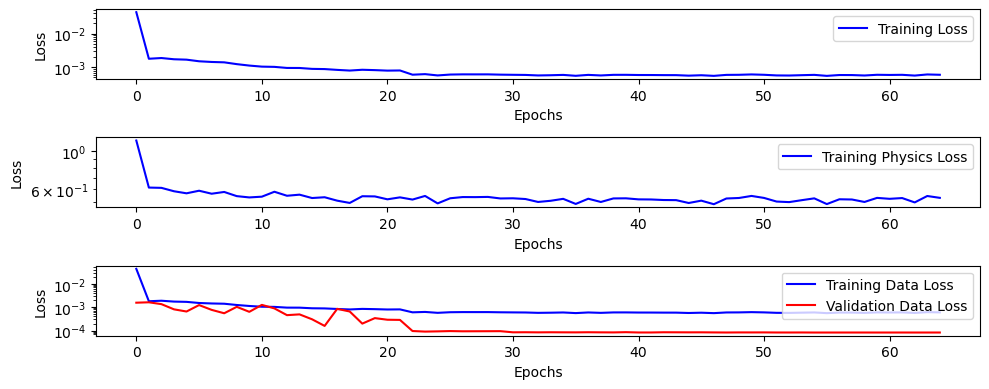

In [76]:
fig = mlp_arch.plot_losses()
fig.show()

## Evaluation

### Load Pre-trained KAN Best Model

In [90]:
torch.manual_seed(42)

input_size = len(kan_features)
output_size = len(target)

trained_kan = KAN(width=[input_size, 12, 6, output_size],
                  grid=12,
                  grid_range=[-5, 5],
                  k=3,
                  auto_save=False,
                  ckpt_path=str(CHECKPOINT_PATH),
                  seed=SEED,
                  device=DEVICE)

# Defines optimizer
optimizer = partial(optim.Adam, lr=1e-2)
scheduler = partial(optim.lr_scheduler.ReduceLROnPlateau,
                    mode='min',
                    factor=0.1,
                    patience=5,
                    min_lr=1e-6)


# Defines a MSE loss function
loss_fn = torch.nn.MSELoss(reduction='mean')

trained_kan_arch = Architecture(model=trained_kan,
                                loss_fn=loss_fn,
                                physics_fn=None,
                                partial_optimizer=optimizer,
                                partial_scheduler=scheduler,
                                use_weighted_pi=True,
                                lamb=0,
                                lamb_l1=0,
                                lamb_entropy=0,
                                lamb_coef=0,
                                lamb_coefdiff=0,
                                lambda_physics=1e-3,
                                singularity_avoiding=True,
                                device=DEVICE
                                )

trained_kan_arch.load_checkpoint('../output/marmousi/best/best.pt')

/home/m2ai/PIKANRT/src/utils/architecture.py:395: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/home/m2ai/PIKANRT/src/utils/architecture.py:398: FutureWarning:

You are usi

### Load Pre-trained MLP Model

In [91]:
torch.manual_seed(42)

input_size = len(kan_features)
output_size = len(target)

trained_mlp = nn.Sequential(
    nn.Linear(input_size, 36),
    nn.ReLU(),
    nn.Linear(36, 36),
    nn.ReLU(),
    nn.Linear(36, 36),
    nn.ReLU(),
    nn.Linear(36, 36),
    nn.ReLU(),
    nn.Linear(36, output_size)
)


# Defines optimizer
optimizer = partial(optim.Adam, lr=1e-2)
scheduler = partial(optim.lr_scheduler.ReduceLROnPlateau,
                    mode='min',
                    factor=0.1,
                    patience=5,
                    min_lr=1e-6)


# Defines a MSE loss function
loss_fn = torch.nn.MSELoss(reduction='mean')

trained_mlp_arch = ArchitectureMLP(model=trained_mlp,
                                   loss_fn=loss_fn,
                                   physics_fn=physics_loss_fn,
                                   partial_optimizer=optimizer,
                                   partial_scheduler=scheduler,
                                   use_weighted_pi=True,
                                   lamb=0,
                                   lambda_physics=1e-3,
                                   device=DEVICE
                                   )

trained_mlp_arch.load_checkpoint(model_save_path)

Checkpoint successfully loaded from 'output/mlp/mlp.pt'


/home/m2ai/PIKANRT/src/utils/architecture.py:830: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [94]:
def evaluate_model(
    arch: Union[Architecture, ArchitectureMLP],
    df_test_filename: str,
    target: list[str] = target,
    kan_features: list[str] = kan_features
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Evaluates a trained model architecture on a test dataset.

    Args:
        arch (Architecture or ArchitectureMLP): The trained model architecture to evaluate.
        df_test_filename (str): Path to the test dataset CSV file.
        target (list[str], optional): List of target column names. Defaults to global `target`.
        kan_features (list[str], optional): List of input feature names for prediction. Defaults to global `kan_features`.

    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: 
            - DataFrame with predicted values and input features.
            - DataFrame with evaluation scores comparing predictions to ground truth.
    """
    df_test = pd.read_csv(df_test_filename)
    predictions = arch.predict(df_test[kan_features].values)
    df_pred = pd.DataFrame(predictions, columns=target)
    df_pred = df_test[kan_features].join(df_pred)
    df_score = score(df_pred[target].values, df_test[target].values)
    return df_pred, df_score
    

In [95]:
df_test_filename = DATA_PATH/'test_mlp.csv'

df_pred_mlp, df_score_mlp = evaluate_model(
    arch=trained_mlp_arch,
    df_test_filename=df_test_filename,
    target=target,
    kan_features=kan_features
)

df_pred_kan, df_score_kan = evaluate_model(
    arch=trained_kan_arch,
    df_test_filename=df_test_filename,
    target=target,
    kan_features=kan_features
)

### Score comparison

In [96]:
df_score_kan

,X,Z,Px,Pz
R²,0.999946,0.999822,0.988595,0.992535
MAPE,0.061208,0.261534,0.994985,2.035807
MAE,0.003294,0.003245,0.004572,0.005283
MSE,0.000021,0.000019,0.000035,0.000059
RMSE,0.004564,0.004326,0.005930,0.007708


In [97]:
df_score_mlp

,X,Z,Px,Pz
R²,0.999840,0.999437,0.971356,0.986932
MAPE,0.107489,0.474756,1.597070,2.917990
MAE,0.005818,0.005893,0.007367,0.007798
MSE,0.000061,0.000059,0.000088,0.000104
RMSE,0.007841,0.007705,0.009397,0.010198


### Prediction time comparison

First, let's evaluate the Runge-Kutta method.

In [98]:
data_gen = DataGeneratorMarmousi(
    x_range=x_range,
    z_range=z_range
)

In [99]:
df_test = pd.read_csv(DATA_PATH/'test_mlp.csv')

In [102]:
unique_initial_conditions = (df_test[kan_features]
                             .drop(columns=['t'])
                             .drop_duplicates())
print("Shape of unique_initial_conditions:", unique_initial_conditions.shape)

Shape of unique_initial_conditions: (323, 3)


Here, we are tracing 323 ray trajectories.

In [ ]:
%%timeit -n 3 -r 7

rays = data_gen.run_batch(x0_vec=unique_initial_conditions['x0'],
                          z0_vec=unique_initial_conditions['z0'],
                          theta0_vec=unique_initial_conditions['theta0_p'],
                          vp=vp,
                          factor=30,
                          t_max=0.4
                          )

The Second order Runge-Kutta method took `29 s ± 99.4 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)`. But 13 seconds are basically the B-splines filter, so we can consider a 16 s ± 99.4 ms to be fair.

Now, we can compare with the proposed PIKAN model.

In [104]:
%%timeit -n 3 -r 7

predictions = trained_kan_arch.predict(df_test[kan_features].values)

66.6 ms ± 43.7 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


The proposed PIKAN model executed in just `66.6 ms ± 43.7 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)`.

In [105]:
%%timeit -n 3 -r 7

predictions = trained_mlp_arch.predict(df_test[kan_features].values)

The slowest run took 29.19 times longer than the fastest. This could mean that an intermediate result is being cached.
18.9 ms ± 21.6 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


PINNs are even faster than PIKANs, once it executed in just `18.9 ms ± 21.6 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)`.